In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q torch
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from datasets import load_dataset
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from sklearn.model_selection import StratifiedKFold
import os
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from transformers.utils import logging

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load and split data into test set
df = pd.read_csv('./drive/MyDrive/w266/project/labeled_data.csv')
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])

train_val_df.to_json("train.json", orient="records", lines=True)
test_df.to_json("test.json", orient="records", lines=True)

print(f"Training set: {len(train_val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 389 samples
Test set: 69 samples


In [ ]:
train_val_df.head()

,Unnamed: 0,interviewer,question,interviewee,response,follow-up,label_claude,label_openai,label_google,label
271,271,Christina Greer,Do you think people with felony convictions sh...,Jim Walden,I do. I do. I think that a felony conviction s...,And just to clarify what you’re saying about t...,0,0,0,0
189,189,Alyssa Katz,So going back to the subway teams that you're ...,Zohran Mamdani,I think that involuntary commitment should be ...,That was in thecity.nyc,0,0,0,0
317,317,Nicole Gelinas,On public safety and quality of life. Although...,Zellnor Myrie,"I’m going to try to recall all three, and migh...","Just on violent criminals, just on convicted c...",0,0,0,0
197,197,Harry Siegel,I’m just asking the how. If he comes to visit ...,Zohran Mamdani,In the same manner that we honor warrants that...,"So, anything that voters should know about you...",0,0,0,0
144,144,Josh Greenman,What’s the answer to the question of how to do...,Zohran Mamdani,I think part of it is expanding the approach a...,Do you think you’d be able to do that with ‘Go...,0,0,0,0


In [ ]:
# load ALBERT tokenizer trained on QNLI
albert_qnli_tokenizer = "./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_tokenizer"
albert_qnli = "./drive/MyDrive/w266/project/model_checkpoints/albert_qnli"

tokenizer = AlbertTokenizer.from_pretrained(albert_qnli_tokenizer)

In [ ]:
# set up for training
def preprocess_function(examples):
    return tokenizer(examples["question"], examples["response"], truncation=True, padding="max_length", max_length=512)

labels = train_val_df["label"].tolist()

num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
# weight classes due to imbalanced data set
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)

print(class_weights)


{0: np.float64(0.538781163434903), 1: np.float64(6.946428571428571)}


In [ ]:
# add evaluation measures
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

In [ ]:
# create instance of trainer class for weighted training
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.logits

          loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
          loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

          return (loss, outputs) if return_outputs else loss

In [ ]:
# loop through folds for cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, labels)):
    print(f"Training on Fold {fold+1}/{num_folds}")

    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)

    model = AlbertForSequenceClassification.from_pretrained(albert_qnli, num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"./logs_fold_{fold}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    logging.set_verbosity_error()

    trainer.train()

    print(f"Evaluation for Fold {fold+1}")
    trainer.evaluate()

Training on Fold 1/4


Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.698384,0.887755,0.166667,0.142857,0.153846
2,No log,0.781379,0.714286,0.080000,0.285714,0.125000
3,No log,0.910916,0.887755,0.000000,0.000000,0.000000
4,No log,0.917838,0.897959,0.000000,0.000000,0.000000


Evaluation for Fold 1


Training on Fold 2/4


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

{'eval_loss': 0.7560286521911621, 'eval_accuracy': 0.8969072164948454, 'eval_precision': 0.2, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.16666666666666666, 'eval_runtime': 3.3473, 'eval_samples_per_second': 28.978, 'eval_steps_per_second': 2.091, 'epoch': 1.0}
{'eval_loss': 0.6906799077987671, 'eval_accuracy': 0.8969072164948454, 'eval_precision': 0.2857142857142857, 'eval_recall': 0.2857142857142857, 'eval_f1': 0.2857142857142857, 'eval_runtime': 3.3996, 'eval_samples_per_second': 28.533, 'eval_steps_per_second': 2.059, 'epoch': 2.0}
{'eval_loss': 0.7331814169883728, 'eval_accuracy': 0.8556701030927835, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3557, 'eval_samples_per_second': 28.906, 'eval_steps_per_second': 2.086, 'epoch': 3.0}
{'eval_loss': 0.7631527781486511, 'eval_accuracy': 0.865979381443299, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3365, 'eval_samples_per_second': 29.072, 'eval_steps_per_second': 2.098

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

{'eval_loss': 0.814216136932373, 'eval_accuracy': 0.8247422680412371, 'eval_precision': 0.08333333333333333, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.10526315789473684, 'eval_runtime': 3.3388, 'eval_samples_per_second': 29.052, 'eval_steps_per_second': 2.097, 'epoch': 1.0}
{'eval_loss': 1.1369678974151611, 'eval_accuracy': 0.8556701030927835, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.349, 'eval_samples_per_second': 28.964, 'eval_steps_per_second': 2.09, 'epoch': 2.0}
{'eval_loss': 1.0104776620864868, 'eval_accuracy': 0.8865979381443299, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3952, 'eval_samples_per_second': 28.57, 'eval_steps_per_second': 2.062, 'epoch': 3.0}
{'eval_loss': 0.9135235548019409, 'eval_accuracy': 0.865979381443299, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3875, 'eval_samples_per_second': 28.635, 'eval_steps_per_second': 2.066, 'epoch': 4.0}
{'train_runtime':

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

{'eval_loss': 0.6630120873451233, 'eval_accuracy': 0.7938144329896907, 'eval_precision': 0.15789473684210525, 'eval_recall': 0.42857142857142855, 'eval_f1': 0.23076923076923078, 'eval_runtime': 3.545, 'eval_samples_per_second': 27.363, 'eval_steps_per_second': 1.975, 'epoch': 1.0}
{'eval_loss': 0.7345861792564392, 'eval_accuracy': 0.8556701030927835, 'eval_precision': 0.1111111111111111, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.125, 'eval_runtime': 3.3997, 'eval_samples_per_second': 28.532, 'eval_steps_per_second': 2.059, 'epoch': 2.0}
{'eval_loss': 0.9955459237098694, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.3925, 'eval_samples_per_second': 28.592, 'eval_steps_per_second': 2.063, 'epoch': 3.0}
{'eval_loss': 1.1464756727218628, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.4285, 'eval_samples_per_second': 28.292, 'eval_steps_per_second': 2

In [ ]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses_tokenizer', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses_tokenizer/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses_tokenizer/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses_tokenizer/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses_tokenizer/added_tokens.json')

In [ ]:
train_dataset_final = Dataset.from_pandas(train_val_df).map(preprocess_function, batched=True)

model = AlbertForSequenceClassification.from_pretrained(albert_qnli, num_labels=2)

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_final,
    eval_dataset=train_dataset_final,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logging.set_verbosity_error()

trainer.train()

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-a565fff8776d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.6148759126663208, 'eval_accuracy': 0.9254498714652957, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 12.2212, 'eval_samples_per_second': 31.83, 'eval_steps_per_second': 4.009, 'epoch': 1.0}
{'eval_loss': 0.6160420179367065, 'eval_accuracy': 0.9331619537275064, 'eval_precision': 0.75, 'eval_recall': 0.10714285714285714, 'eval_f1': 0.1875, 'eval_runtime': 12.2213, 'eval_samples_per_second': 31.83, 'eval_steps_per_second': 4.009, 'epoch': 2.0}
{'eval_loss': 0.5852985978126526, 'eval_accuracy': 0.8071979434447301, 'eval_precision': 0.19480519480519481, 'eval_recall': 0.5357142857142857, 'eval_f1': 0.2857142857142857, 'eval_runtime': 12.2234, 'eval_samples_per_second': 31.824, 'eval_steps_per_second': 4.009, 'epoch': 3.0}
{'eval_loss': 0.5066854953765869, 'eval_accuracy': 0.8894601542416453, 'eval_precision': 0.2972972972972973, 'eval_recall': 0.39285714285714285, 'eval_f1': 0.3384615384615385, 'eval_runtime': 12.2039, 'eval_samples_per_second': 

TrainOutput(global_step=200, training_loss=0.5818023300170898, metrics={'train_runtime': 391.5984, 'train_samples_per_second': 7.947, 'train_steps_per_second': 0.511, 'train_loss': 0.5818023300170898, 'epoch': 8.0})

In [ ]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2/added_tokens.json')

In [ ]:
saved_model = "./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2"
saved_tokenizer = "./drive/MyDrive/w266/project/model_checkpoints/albert_qnli_responses2"

tokenizer = AlbertTokenizer.from_pretrained(saved_tokenizer)
model = AlbertForSequenceClassification.from_pretrained(saved_model, num_labels=2)


In [ ]:
test_dataset = Dataset.from_pandas(test_df)
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
def predict(example):
    encoding = tokenizer(example['question'], example['response'],
                         truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

test_predictions = [predict(example) for example in test_dataset]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

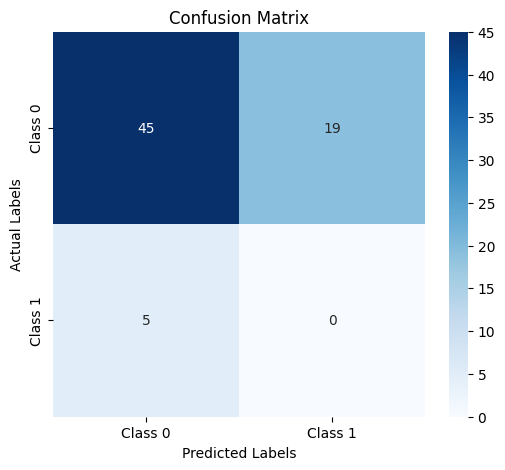

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = test_df['label'].to_list()

cm = confusion_matrix(labels, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
